In [1]:
library("knitr")
# library("caret")       # for general model fitting
library("rpart")       # for fitting decision trees
library("ipred")  
library("foreach")     # for parallel processing with for loops
library("ggplot2")
library("rpart.plot")
library("doParallel")  # for parallel backend to foreach
library("data.table")
library("tidymodels")
library("randomForest")

knitr::opts_chunk$set(echo = TRUE)

Loading required package: iterators

Loading required package: parallel

Registered S3 method overwritten by 'tune':
  method                   from   
  required_pkgs.model_spec parsnip

── Attaching packages ───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────── tidymodels 0.1.3 ──

✔ broom        0.7.6      ✔ rsample      0.1.0 
✔ dials        0.0.9      ✔ tibble       3.1.6 
✔ dplyr        1.0.6      ✔ tidyr        1.1.3 
✔ infer        0.5.4      ✔ tune         0.1.5 
✔ modeldata    0.1.0      ✔ workflows    0.2.2 
✔ parsnip      0.1.7      ✔ workflowsets 0.0.2 
✔ purrr        0.3.4      ✔ yardstick    0.0.8 
✔ recipes      0.1.16     

── Conflicts ──────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────── tidymodels_conflicts() ──
✖ purrr::accumulate() masks foreach::ac

## Reading the data

For this practical session on logistic regression we are using a dataset on the relationship between cleft lip in dogs (Nova Scotia Duck Tolling Retriever, NSDTR) and SNP genotypes ([data](https://datadryad.org/stash/dataset/doi:10.5061/dryad.j8r8q); [paper](https://journals.plos.org/plosgenetics/article?id=10.1371/journal.pgen.1005059)).

The public dataset downloaded from Dryad is a *Plink* `.tped/.tfam` file. The data have been preprocessed:

- filtered (SNP quality, call-rate, MAF)
- imputed (imputation of missing genotypes using LHCI: localised haplotype-clustering imputation)
- selected (only SNPs on chromosomes 25, 26, 27, 28, 29)

In [2]:
dogs <- fread("../data/dogs_imputed.raw")
dogs <- dogs %>%
  select(-c(IID,FID,PAT,MAT,SEX))

dogs$PHENOTYPE = dogs$PHENOTYPE-1

## Trees and bagging

#### Classification tree

Let's start with a classification tree. We split the data in training and testing sets:

- function `rpart` (from the *rpart* package)
- method = "class" (classification)
- `minsplit`: minimum number of observations (records) in a split (splits with fewer than 3 records will not be considered/attempted)

In [6]:
seed = 157
set.seed(seed)

##Training data
n = nrow(dogs) ## sample size
n_training = round(0.75*n,0)
n_test = n - n_training
training_records <- sample(n,n_training)
x_train <- dogs[training_records,]
x_test <- dogs[-training_records,-1]
y_test <- as.factor(dogs[-training_records,]$PHENOTYPE)
print(y_test)

 [1] 1 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 1
Levels: 0 1


In [7]:
table(x_train$PHENOTYPE)


 0  1 
85  9 

Then fit the classification tree model to the training set:

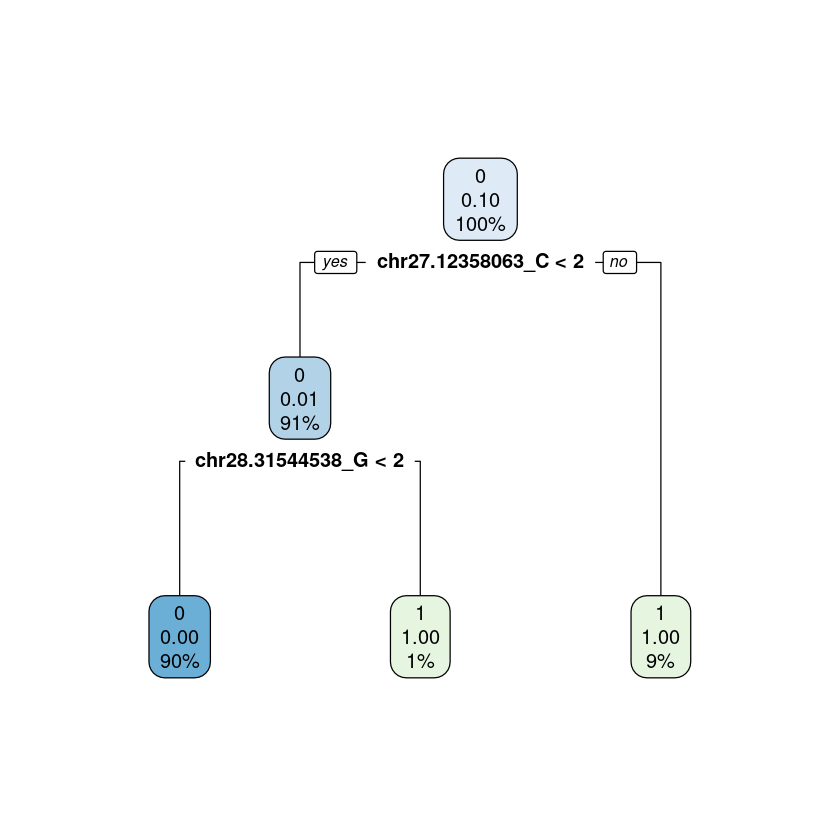

In [8]:
##Model without bagging
no_bag_model <- rpart(PHENOTYPE ~ ., data = x_train, method = "class", control = rpart.control(minsplit = 3))

rpart.plot(no_bag_model)

In the *tree-plot* we see:

- the **classification**
- the modelled class probability $\rightarrow$ $P(y=1|x)$ (i.e. the probability of the class conditioned on the node)
- the percentage of observations used at that node

With the trained model we can make predictions in the test set:

In [9]:
predictions <- predict(no_bag_model, x_test, type = "class")
table(predictions, y_test)

           y_test
predictions  0  1
          0 27  0
          1  0  4

#### Bagging

We now take 10 bootstrapped samples of the data, and fit a classification tree to each sample. We use OOB observations to measure the prediction error.
At each bagging replicate (bootstrapped sample) typically $1/3$ of the observations are not used for training (out-of-bag -OOB- observations), and can naturally be used to measure the prediction error:

In [ ]:
n_model = 10
bagged_models <- list()
oob <- list()
for (i in 1:n_model) {
  
  records = seq(1,nrow(dogs))
  new_sample <- sample(records, size=nrow(dogs), replace=TRUE) ## bootstrapping here!!
  oob <- c(oob, list(records[!(records %in% new_sample)]))
  bagged_models <- c(
    bagged_models,
    list(rpart(PHENOTYPE ~ ., dogs[new_sample,], control = rpart.control(minsplit=3))))
}

In [ ]:
##Getting estimate from the bagged model
oob_results = data.frame("rep"=NULL, "error"=NULL)
i = 1
for (bag_model in bagged_models) {

  preds = predict(bag_model, dogs[oob[[i]],-1]) ## predict by applying the trained model on the OBB data
  obs = dogs$PHENOTYPE[oob[[i]]]
  oob_results = rbind.data.frame(oob_results, data.frame("rep"=i, "error"=1-sum(preds == obs)/length(preds))) ## check obs == preds
  i = i+1
}

In [ ]:
kable(oob_results)

In [ ]:
print(paste("average OOB error:" , mean(oob_results$error)))

Alternatively, we can proceed with splitting the data in training and testing sets, fit the classification trees to bootstrapped replicates of the training data, and then estimate the error rate on the test data.

Also here we will have OOB observations, but the error rate in this case would tend to be overestimated since the training set is smaller than the original dataset.

In [10]:
n_model = 10
bagged_models <- list()
oob <- list()
for (i in 1:n_model) {
  
  new_sample <- sample(training_records, size=length(training_records), replace=TRUE)
  oob <- c(oob, list(training_records[!(training_records %in% new_sample)]))
  bagged_models <- c(
    bagged_models,
    list(rpart(PHENOTYPE ~ ., dogs[new_sample,], control = rpart.control(minsplit=3))))
}

In [11]:
##Getting estimate from the bagged model
bagged_result = NULL
i = 0
for (bag_model in bagged_models) {
 
  if (is.null(bagged_result)) {
    bagged_result = predict(bag_model, x_test)
  } else {
   bagged_result=(i*bagged_result+predict(bag_model, x_test))/(i+1) ## % of times each observation was classified as 1
  }
i = i+1
}


diff = abs(bagged_result - (as.integer(y_test)-1)) ## absolute differences between predictions and observations (averaged over the n replicates of the model)
error = sum(n_model*diff)/(length(y_test)*n_model) ## average error over number of predictions (size of test set time n. of replicates)
print(error)

[1] 0.003225806


Total test error rate is `r error`.
The breakdown in FPR and FNR is shown below:

In [12]:
df <- data.frame("pred"=bagged_result,"obs"=as.integer(y_test)-1)
df %>%
  group_by(obs) %>%
  summarise(N=n(),err=sum(10*abs(pred-obs))/(N*10))

obs,N,err
<dbl>,<int>,<dbl>
0,27,0.003703704
1,4,0.000000000


## Random Forest

We can now make the next step from bagging (averaging over bootstrapped trees) to Random Forest (adding randomly sampled subsets of features to bootstrapped data):

- first, split the data in training and test sets (we keep y and x separate here)
- then we fit a RF model to the training set, without tuning any hyperparameters (for now)

In [ ]:
##Training data
n = nrow(dogs) ## sample size
n_training = round(0.8*n,0)
n_test = n - n_training
training_records <- sample(n,n_training)
x_train <- as.matrix(dogs[training_records,-1])
y_train <- as.factor(dogs[training_records,]$PHENOTYPE)
x_test <- as.matrix(dogs[-training_records,-1])
y_test <- as.factor(dogs[-training_records,]$PHENOTYPE)
print(y_test)

In [ ]:
rf.dogs <- randomForest(x = x_train, y = y_train, ntree = 10)
rf.dogs

#### Let's tune it up a little!

Now we use a convenient built-in function to tune hyperparameters in random forest: the `tuneRF` function:

- we tune just the number of variables to sample in each tree, `mtry`

In [ ]:
tuned_rf <- tuneRF(x_train, y_train, mtryStart = 25, ntreeTry=50, stepFactor=1.5, improve=0.01,
       trace=TRUE, plot=TRUE)

head(tuned_rf)
num_row <- which(tuned_rf[,2] == min(tuned_rf[,2])) ## row corresponding to min OOB error
num_vars <- tuned_rf[num_row,1]  ## mtry value corresponding to min OOB error
print(num_vars)

Now we fit a final RF model with the tuned value for `mtry` (number of variables subsampled in each tree), and build a small forest with 100 trees:

In [ ]:
rf.dogs <- randomForest(x = x_train, y = y_train, ntree = 100, mtry = num_vars, importance = TRUE)

imp <- as.data.frame(importance(rf.dogs))
summary(imp)
top_vars <- imp %>%
  arrange(desc(MeanDecreaseGini)) %>%
  top_n(20) %>%
  select(MeanDecreaseGini) %>%
  mutate(name_var = gsub("\\_.*$","",row.names(.)))

top_vars$name_var <- factor(top_vars$name_var, levels = rev(top_vars$name_var))

#### Variable importance

In [ ]:
p <- ggplot(top_vars, aes(x=name_var,y=MeanDecreaseGini)) + geom_bar(stat="identity")
p <- p + theme(axis.text.x = element_text(angle = 90, hjust = 1))
p <- p + coord_flip()
p

#### Predictions

In [ ]:
probs <- predict(rf.dogs, newdata = x_test, type = "prob")
predictions <- ifelse(probs[,"1"] > 0.5, 1, 0 )
table(predictions, y_test)

In [ ]:
library("ROCit")

load("ROClogit.RData")
load("ROClasso.RData")

ROCit_rf <- rocit(score=probs[,"1"],class=y_test)
plot(ROCit_rf, col = c(1,"gray50"), 
     legend = FALSE, YIndex = FALSE)
lines(ROCit_lasso$TPR~ROCit_lasso$FPR,col = 2, lwd = 2)
lines(ROCit_logit$TPR~ROCit_logit$FPR,col = 3, lwd = 3)
legend("bottomright", col = c(1,2,3),
       c("RF","Lasso", "Logistic regression"), lwd = 2)